In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy.stats import spearmanr
import re
import arviz as az
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import cellbayesassay as cba
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
my_treatments = ['TI21', 'TI22', 'TI26']

concentrations = {
    ('TI21', 1): 100e-6,
    ('TI21', 2): 10e-6,
    ('TI21', 3): 1e-6,
    ('TI22', 1): 10e-6,
    ('TI22', 2): 3e-6,
    ('TI22', 3): 1e-6,
    ('TI26', 1): 10e-6,
    ('TI26', 2): 3e-6,
    ('TI26', 3): 1e-6,
}



def get_concentration(TI, conc, concentrations=concentrations):
    TI = TI.strip()
    if re.match('^TI.*', TI):
        val = concentrations[(TI, conc)]
    else:
        val = concentrations[TI]
    return(val)

fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-edited.xlsx'
datad = {}

def read_data(sheet_name, assays, mean_sem_col='Group', skiprows=0):
    data = pd.read_excel(fpath, sheet_name=sheet_name, skiprows=skiprows)
    data = data.loc[~ data[mean_sem_col].isin(['mean', 'SEM'])]
    data['TI'] = data.TI.apply(lambda s: re.sub('TI\\s+', 'TI', s)).str.strip()
    data = data.applymap(lambda x: 0 if x == '<LOD' else x)
    data = data.applymap(lambda x: pd.NA if x == 'N/A' else x)
    data_nonassays = data.loc[:, ~ data.columns.isin(assays)]
    data_assays = pd.concat([data[a].astype(np.float64).to_frame(a) for a in assays], axis=1)
    data = pd.concat([data_nonassays, data_assays], axis=1)
    return(data)

def add_concentrations(data, concentrations):
    data['concentration'] = data.apply(lambda r: get_concentration(r.loc['TI'], r.loc['conc'], concentrations=concentrations), axis=1)
    data['conc_log10'] = data.concentration.apply(np.log10)
    return(data)


In [3]:
concentrations_LPS = concentrations.copy()
concentrations_LPS.update({
    'LPS': 1e-9,
    #'VC+L': 1e-9,
})
sheet_name = 'LPS'
assays_LPS = ['IFN-γ', 'IL-10', 'IL-12p70', 'IL-1β', 'IL-2', 'IL-4', 'IL-5', 'IL-6', 'KC/GRO', 'TNF-α']
data = read_data(sheet_name=sheet_name, assays=assays_LPS, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_LPS)
datad[sheet_name] = data
data

,Cohort,Group,IRN,TI,conc,IFN-γ,IL-10,IL-12p70,IL-1β,IL-2,IL-4,IL-5,IL-6,KC/GRO,TNF-α,concentration,conc_log10
0,2.0,I1,TI 21 C1_1,TI21,1.0,0.000,6.53,48.48,0.61,0.50,0.000,0.00,12938.0,9.36,1734.0,1.000000e-04,-4.0
1,2.0,I1,TI 21 C1_2,TI21,1.0,0.197,8.05,61.95,1.71,1.39,0.000,0.13,13352.0,7.25,1601.0,1.000000e-04,-4.0
2,2.0,I1,TI 21 C1_3,TI21,1.0,0.023,6.97,143.32,0.84,0.46,0.026,0.65,13167.0,9.89,1333.0,1.000000e-04,-4.0
3,2.0,I1,TI 21 C1_4,TI21,1.0,0.038,6.25,4.21,0.72,0.00,0.000,0.00,8040.0,6.21,1670.0,1.000000e-04,-4.0
4,2.0,I1,TI 21 C1_5,TI21,1.0,0.004,5.60,23.70,0.90,0.00,0.000,0.00,6801.0,6.78,1272.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,5.0,LPS 5,VC+LPS_5_2,LPS,NaN,0.019,6.87,44.88,1.52,0.00,0.081,0.17,19845.0,13.87,1989.0,1.000000e-09,-9.0
90,5.0,LPS 5,VC+LPS_5_3,LPS,NaN,0.000,8.26,18.15,1.42,1.59,0.000,0.00,21097.0,12.33,2243.0,1.000000e-09,-9.0
91,5.0,LPS 5,VC+LPS_5_4,LPS,NaN,0.000,7.52,56.22,1.44,0.00,0.000,1.84,21231.0,25.92,2156.0,1.000000e-09,-9.0
92,5.0,LPS 5,VC+LPS_5_5,LPS,NaN,0.012,8.55,82.39,2.39,0.64,0.197,2.00,26174.0,21.33,2811.0,1.000000e-09,-9.0


In [4]:
concentrations_Ab_toxicity = concentrations.copy()
concentrations_Ab_toxicity.update({
    'LC': 1e-9,
})
sheet_name = 'Abeta Toxicity'
assays_Ab_toxicity = ['Viability [% VC]']

data = read_data(sheet_name=sheet_name, assays=assays_Ab_toxicity, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Ab_toxicity)
datad[sheet_name] = data
data

,IRN,TI,conc,Viability [% VC],concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,76.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,83.8,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,81.7,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,99.6,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,86.2,1.000000e-04,-4.0
...,...,...,...,...,...,...
81,LC_2_2,LC,NaN,74.7,1.000000e-09,-9.0
82,LC_2_3,LC,NaN,65.4,1.000000e-09,-9.0
83,LC_2_4,LC,NaN,73.9,1.000000e-09,-9.0
84,LC_2_5,LC,NaN,68.6,1.000000e-09,-9.0


In [5]:
concentrations_Ab_release = concentrations.copy()
concentrations_Ab_release.update({
    'VC': 1e-9,
})
sheet_name = 'Abeta release'
assays_Ab_release = ['Aβ38', 'Aβ40', 'Aβ42']

data = read_data(sheet_name=sheet_name, assays=assays_Ab_release, mean_sem_col='Group', skiprows=1)
data['TI'] = data.TI.apply(lambda s: re.sub('^VC.*', 'VC', s))
data = add_concentrations(data, concentrations=concentrations_Ab_release)
datad[sheet_name] = data
data

,plate,Group,ID,TI,conc,Aβ38,Aβ40,Aβ42,concentration,conc_log10
0,1.0,A1,TI21 c1_1,TI21,1.0,3401.0,14276.0,1128.0,1.000000e-04,-4.0
1,1.0,A1,TI21 c1_2,TI21,1.0,3468.0,14353.0,1011.0,1.000000e-04,-4.0
2,1.0,A1,TI21 c1_3,TI21,1.0,3190.0,13622.0,970.0,1.000000e-04,-4.0
3,1.0,A1,TI21 c1_4,TI21,1.0,4390.0,19144.0,1262.0,1.000000e-04,-4.0
4,1.0,A1,TI21 c1_5,TI21,1.0,3782.0,15602.0,1163.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...,...
81,5.0,K,VC_4_2,VC,NaN,3016.0,15962.0,1406.0,1.000000e-09,-9.0
82,5.0,K,VC_4_3,VC,NaN,2296.0,13190.0,1304.0,1.000000e-09,-9.0
83,5.0,K,VC_4_4,VC,NaN,2517.0,12753.0,1269.0,1.000000e-09,-9.0
84,5.0,K,VC_4_5,VC,NaN,3121.0,16302.0,1644.0,1.000000e-09,-9.0


In [6]:
concentrations_Ab_clearance = concentrations.copy()
concentrations_Ab_clearance.update({
    'Aß': 1e-9,
})
sheet_name = 'Abeta clearance'
assays_Ab_clearance = ['Aβ42 SN', 'Aβ42 Ly']

data = read_data(sheet_name=sheet_name, assays=assays_Ab_clearance, mean_sem_col='Group', skiprows=1)
data['conc'] = data.conc.str.replace('c', '').astype(np.float64)
data = add_concentrations(data, concentrations=concentrations_Ab_clearance)
datad[sheet_name] = data
data

,plate,Group,IRN,TI,conc,Aβ42 SN,Aβ42 Ly,concentration,conc_log10
0,2.0,B4,TI21_c1_1,TI21,1.0,14356.0,23798.0,1.000000e-04,-4.0
1,2.0,B4,TI21_c1_2,TI21,1.0,21196.0,48934.0,1.000000e-04,-4.0
2,2.0,B4,TI21_c1_3,TI21,1.0,24232.0,16946.0,1.000000e-04,-4.0
3,2.0,B4,TI21_c1_4,TI21,1.0,33126.0,56506.0,1.000000e-04,-4.0
4,2.0,B4,TI21_c1_5,TI21,1.0,29952.0,24963.0,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
89,5.0,E7,5_Aß_2,Aß,NaN,24292.0,3212.0,1.000000e-09,-9.0
90,5.0,E7,5_Aß_3,Aß,NaN,NaN,6464.0,1.000000e-09,-9.0
91,5.0,E7,5_Aß_4,Aß,NaN,15038.0,14282.0,1.000000e-09,-9.0
92,5.0,E7,5_Aß_5,Aß,NaN,15654.0,7222.0,1.000000e-09,-9.0


In [7]:
concentrations_GF_withdrawal = concentrations.copy()
concentrations_GF_withdrawal.update({
    'VC': 1e-9,
})
sheet_name = 'GF withdrawal'
assays_GF_withdrawal = ['PI', 'YOPRO', 'MTT', 'LDH']

data = read_data(sheet_name=sheet_name, assays=assays_GF_withdrawal, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_GF_withdrawal)
datad[sheet_name] = data
data

,IRN,TI,conc,PI,YOPRO,MTT,LDH,concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,97.6,85.0,80.8,105.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,82.6,74.3,103.3,119.0,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,105.1,85.6,101.4,120.0,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,129.2,111.9,93.0,120.0,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,107.4,94.6,100.5,119.5,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
89,VC_3_2,VC,NaN,108.1,102.2,127.3,96.9,1.000000e-09,-9.0
90,VC_3_3,VC,NaN,92.3,100.1,104.7,103.1,1.000000e-09,-9.0
91,VC_3_4,VC,NaN,95.3,94.7,112.5,102.6,1.000000e-09,-9.0
92,VC_3_5,VC,NaN,97.1,100.5,97.7,97.4,1.000000e-09,-9.0


In [8]:
concentrations_Tau_phosphorylation = concentrations.copy()
concentrations_Tau_phosphorylation.update({
    'VC': 1e-9,
})
sheet_name = 'Tau phosphorylation'
assays_Tau_phosphorylation = ['Tau [pg/µg prot]', 'pTau (T231)', 'ratio']

data = read_data(sheet_name=sheet_name, assays=assays_Tau_phosphorylation, mean_sem_col='Group', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_Tau_phosphorylation)
datad[sheet_name] = data
data

,Cohort,Group,IRN,TI,conc,Tau [pg/µg prot],pTau (T231),ratio,concentration,conc_log10
0,3.0,E1,TI21_c1_1,TI21,1.0,388833.0,48.0,1.22,1.000000e-04,-4.000000
1,3.0,E1,TI21_c1_2,TI21,1.0,362000.0,46.0,1.27,1.000000e-04,-4.000000
2,3.0,E1,TI21_c1_3,TI21,1.0,580648.0,56.0,0.96,1.000000e-04,-4.000000
3,3.0,E1,TI21_c1_4,TI21,1.0,349775.0,40.0,1.13,1.000000e-04,-4.000000
4,3.0,E1,TI21_c1_5,TI21,1.0,389880.0,44.0,1.14,1.000000e-04,-4.000000
5,3.0,E1,TI21_c1_6,TI21,1.0,584470.0,56.0,0.96,1.000000e-04,-4.000000
8,3.0,E2,TI21_c2_3,TI21,2.0,625281.0,60.0,0.97,1.000000e-05,-5.000000
9,3.0,E2,TI21_c2_4,TI21,2.0,412764.0,45.0,1.08,1.000000e-05,-5.000000
10,3.0,E2,TI21_c2_5,TI21,2.0,617010.0,47.0,0.76,1.000000e-05,-5.000000
11,3.0,E2,TI21_c2_6,TI21,2.0,555671.0,46.0,0.83,1.000000e-05,-5.000000


In [9]:
concentrations_NOG = concentrations.copy()
concentrations_NOG.update({
    'VC': 1e-9,
})
sheet_name = 'NOG'
assays_NOG = ['total neurite length', 'Number of branch points', 'Neurogenesis', 'average neurite length']

data = read_data(sheet_name=sheet_name, assays=assays_NOG, mean_sem_col='IRN', skiprows=0)
data = add_concentrations(data, concentrations=concentrations_NOG)
datad[sheet_name] = data
data

,IRN,TI,conc,total neurite length,Number of branch points,Neurogenesis,average neurite length,concentration,conc_log10
0,TI 21 C1_1,TI21,1.0,103.16050,2496.377,9.15,44.3,1.000000e-04,-4.0
1,TI 21 C1_2,TI21,1.0,86.85951,2097.451,16.09,38.8,1.000000e-04,-4.0
2,TI 21 C1_3,TI21,1.0,90.33200,2178.649,7.94,39.8,1.000000e-04,-4.0
3,TI 21 C1_4,TI21,1.0,101.73460,2635.384,8.26,41.8,1.000000e-04,-4.0
4,TI 21 C1_5,TI21,1.0,95.91431,2441.658,7.97,41.1,1.000000e-04,-4.0
...,...,...,...,...,...,...,...,...,...
81,VC_2_2,VC,NaN,101.94750,2458.427,7.74,37.8,1.000000e-09,-9.0
82,VC_2_3,VC,NaN,100.02430,2350.311,7.83,35.0,1.000000e-09,-9.0
83,VC_2_4,VC,NaN,89.03091,2184.385,7.43,32.7,1.000000e-09,-9.0
84,VC_2_5,VC,NaN,93.77637,2310.594,9.58,33.4,1.000000e-09,-9.0


In [10]:
def get_treatment_data(compound='TI21', data=data, my_treatments=my_treatments):
    mt = my_treatments.copy()
    mt.remove(compound)
    data = data.loc[~ data.TI.isin(mt)]
    return(data)

def data_plotter(assay, data, group_var=None):
    if group_var is not None:
        groups = data[group_var].unique()
        groupd = dict(zip(groups, ['C' + str(i) for i in range(len(groups))]))
        data['color'] = data[group_var].apply(lambda x: groupd[x])
    else:
        data['color'] = 'C0'
    fig, ax = plt.subplots(1, len(my_treatments), sharey=True)
    for axi, compound in zip(ax, my_treatments):
        axi.scatter(x='concentration', y=assay, c='color', data=get_treatment_data(compound, data=data), marker='+')
        axi.set_xscale('log')
        axi.set_title(compound)
    fig.suptitle(assay)
    return((fig, ax))


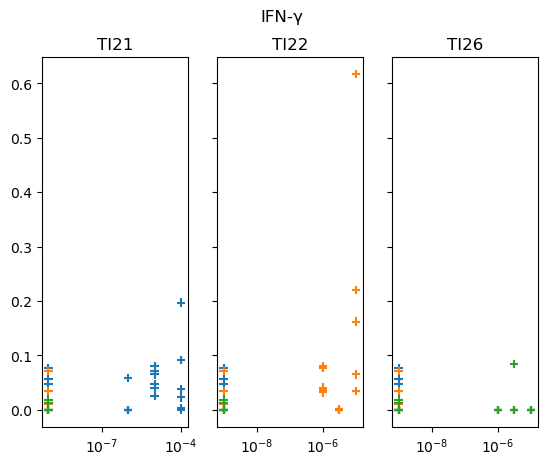

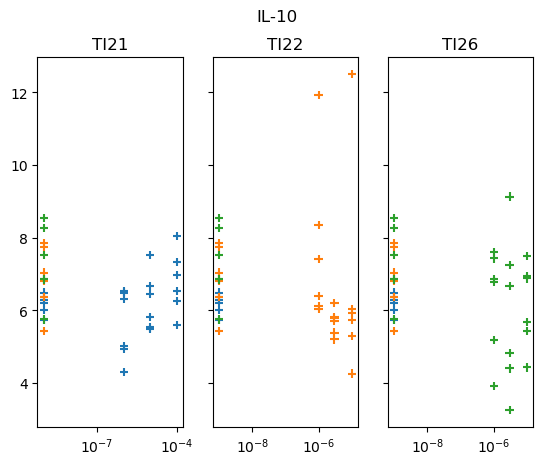

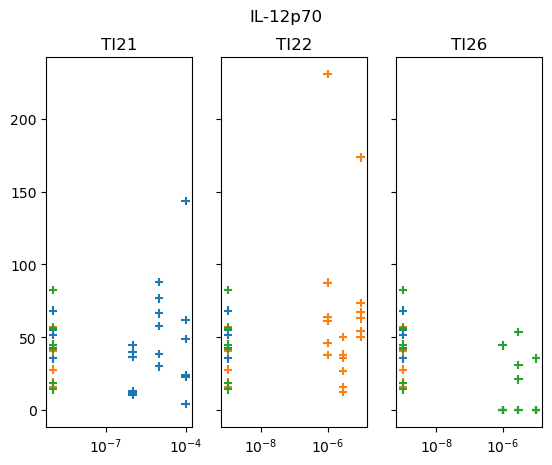

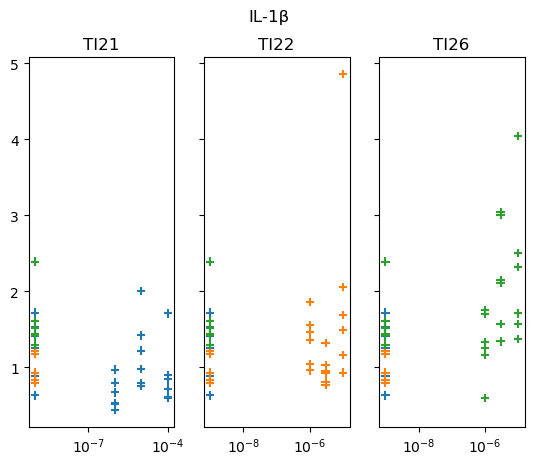

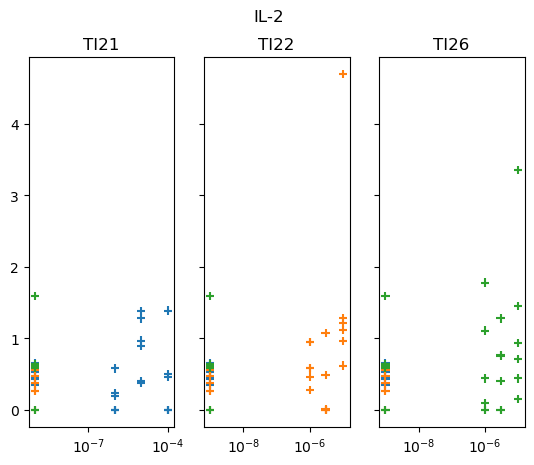

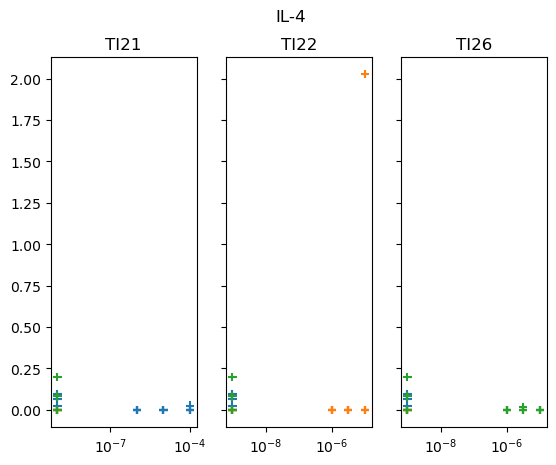

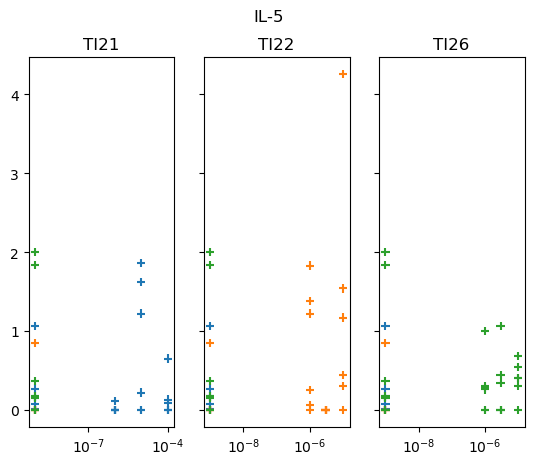

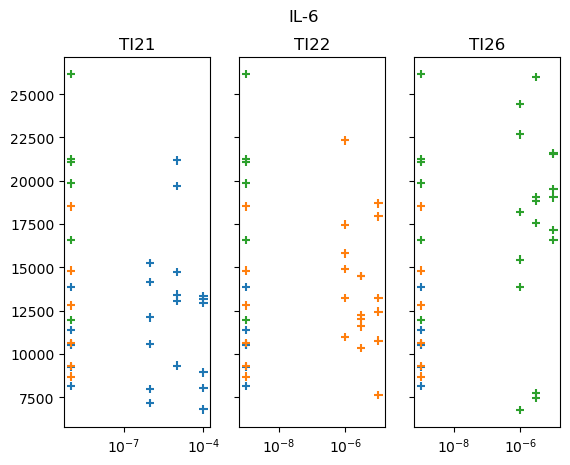

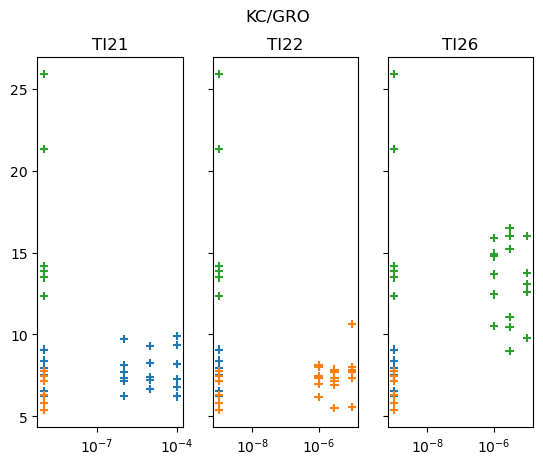

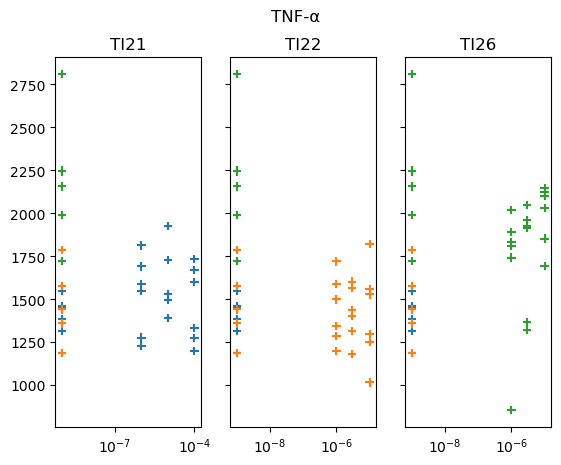

In [11]:
for assay in assays_LPS:
    fig, ax = data_plotter(assay, datad['LPS'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

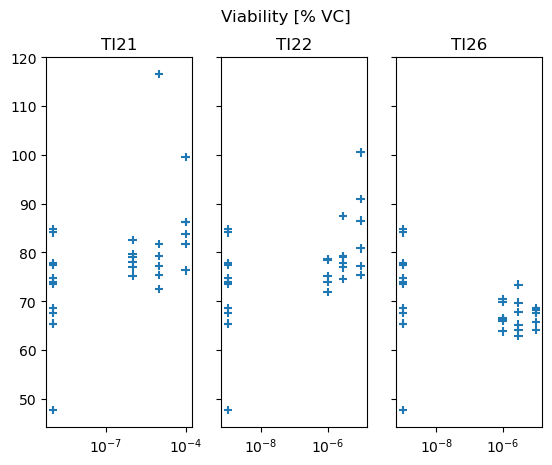

In [12]:
for assay in ['Viability [% VC]']:
    fig, ax = data_plotter(assay, datad['Abeta Toxicity'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

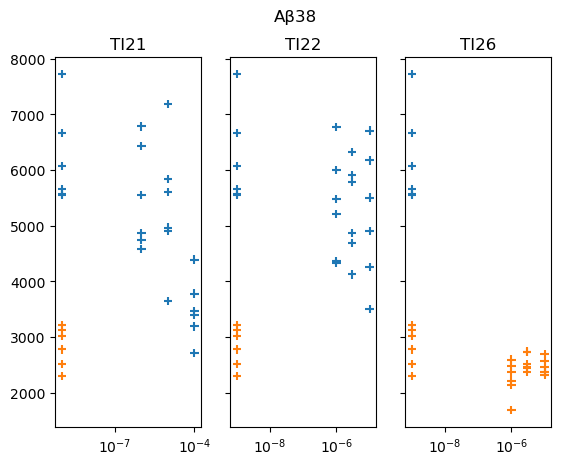

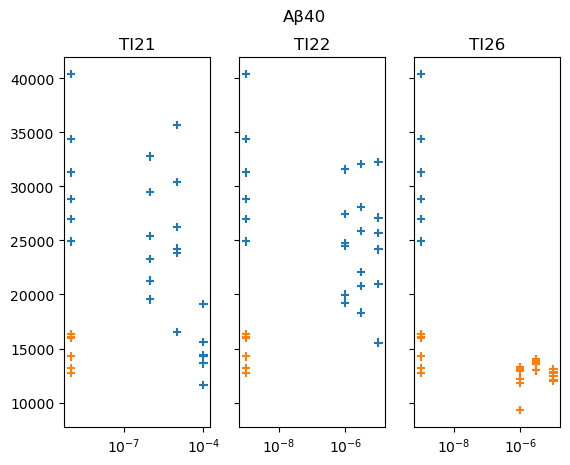

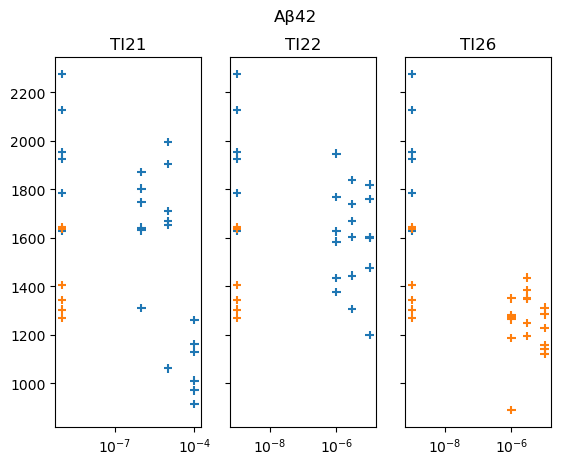

In [13]:
for assay in ['Aβ38', 'Aβ40', 'Aβ42']:
    fig, ax = data_plotter(assay, datad['Abeta release'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

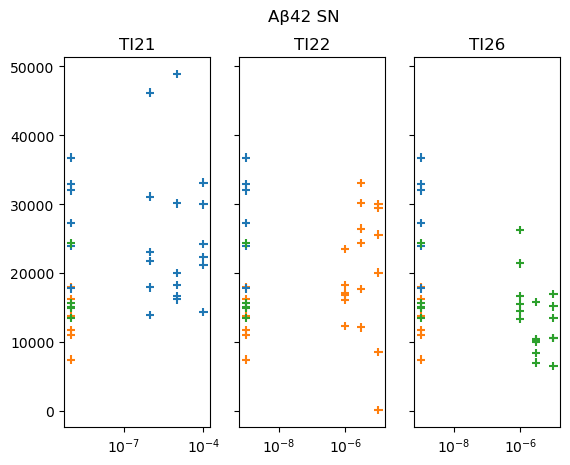

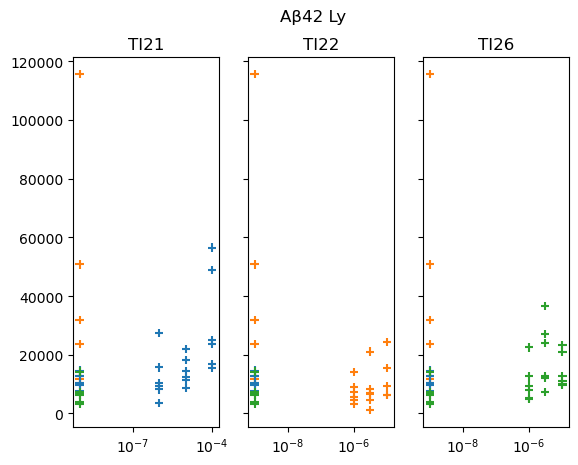

In [14]:
for assay in ['Aβ42 SN', 'Aβ42 Ly']:
    fig, ax = data_plotter(assay, datad['Abeta clearance'], 'plate')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

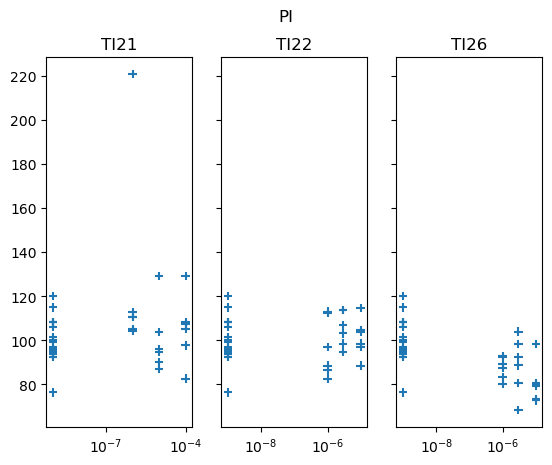

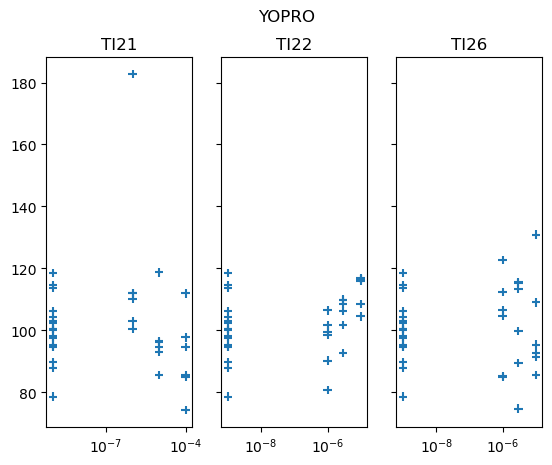

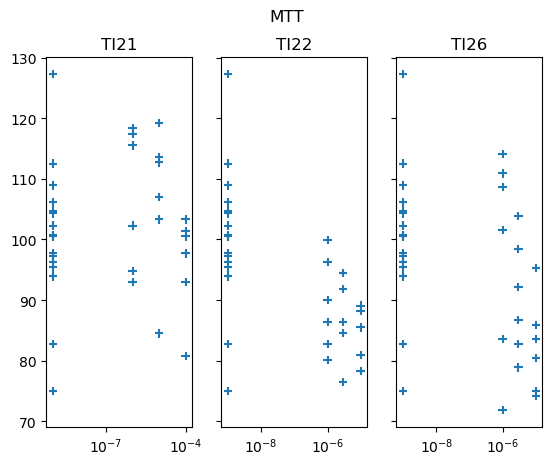

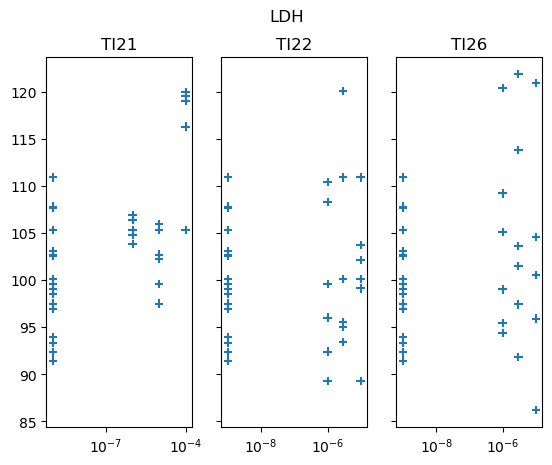

In [15]:
for assay in assays_GF_withdrawal:
    fig, ax = data_plotter(assay, datad['GF withdrawal'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

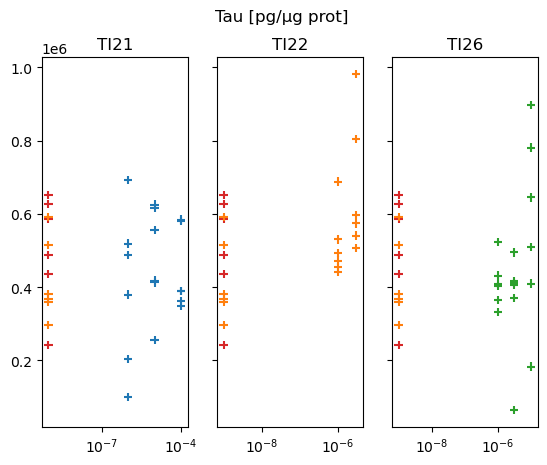

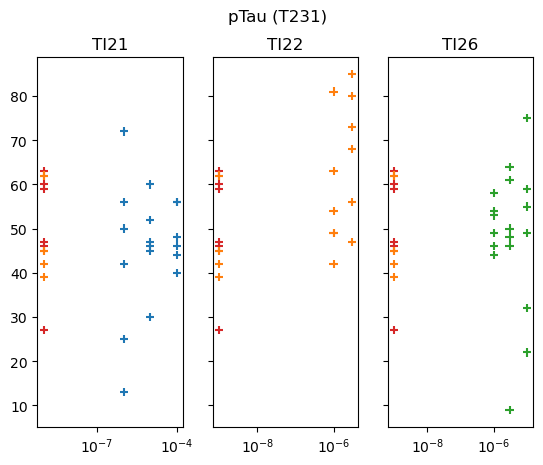

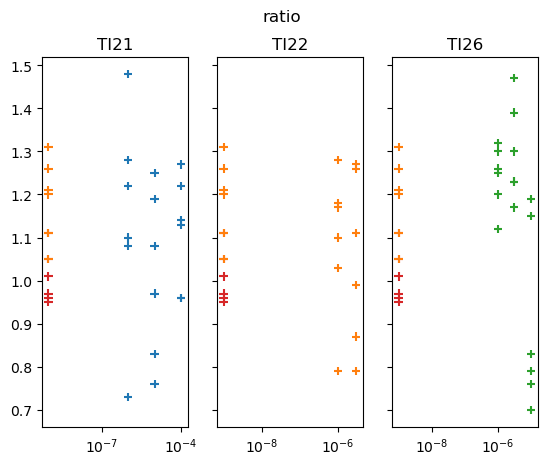

In [16]:
for assay in assays_Tau_phosphorylation:
    fig, ax = data_plotter(assay, datad['Tau phosphorylation'], 'Cohort')
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

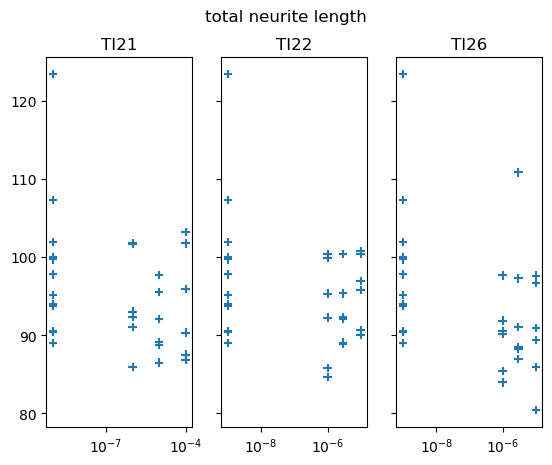

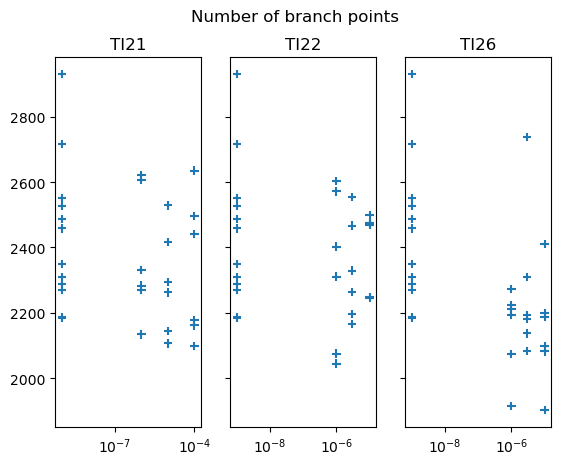

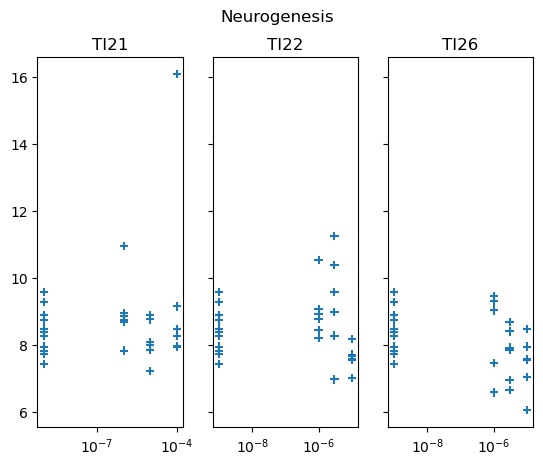

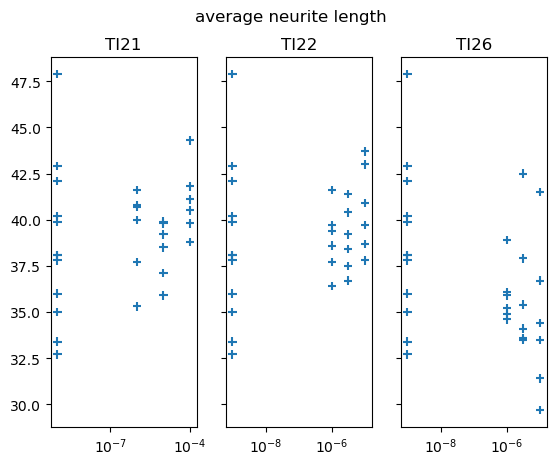

In [17]:
for assay in assays_NOG:
    fig, ax = data_plotter(assay, datad['NOG'])
    attila_utils.savefig(fig, 'data_plot_' + assay.replace('/', '-'))

In [18]:
fpath = '../../resources/cell-based-assays/TI21_22_26_rawdata_sum-controls.csv'
controls = pd.read_csv(fpath, index_col='experiment')
controls

,control_treatment,group_var,TI21,TI22,TI26
experiment,,,,,
LPS,LPS,Cohort,2.0,3.0,5.0
Abeta Toxicity,LC,NaN,NaN,NaN,NaN
Abeta release,VC,plate,1.0,1.0,5.0
Abeta clearance,Aß,plate,2.0,3.0,5.0
GF withdrawal,VC,NaN,NaN,NaN,NaN
Tau phosphorylation,VC,NaN,NaN,NaN,NaN
NOG,VC,NaN,NaN,NaN,NaN


In [19]:
def extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=False):
    data = datad[exper]
    group_var, control_treatment, group_level = controls.loc[exper, ['group_var', 'control_treatment', compound]]
    mask = data.TI.isin([compound, control_treatment])
    if group_var is not np.nan:
        mask = mask & (data[group_var] == group_level)
    data = data.loc[mask]
    data_reshaped = data[[assay, 'concentration', 'conc_log10']]
    activity = data_reshaped[assay] / data_reshaped[assay].std() * 10
    data_reshaped = pd.concat([data_reshaped, activity.to_frame('activity')], axis=1)
    if return_data_reshaped:
        return(data_reshaped)
    y_obs = data_reshaped['activity'].values
    x_obs = data_reshaped['conc_log10'].values
    return((y_obs, x_obs))

extract_regr_data('Abeta clearance', 'Aβ42 Ly', 'TI21', return_data_reshaped=True)

,Aβ42 Ly,concentration,conc_log10,activity
0,23798.0,1.000000e-04,-4.0,19.181481
1,48934.0,1.000000e-04,-4.0,39.441407
2,16946.0,1.000000e-04,-4.0,13.658685
3,56506.0,1.000000e-04,-4.0,45.544532
4,24963.0,1.000000e-04,-4.0,20.120486
5,15538.0,1.000000e-04,-4.0,12.523819
8,21978.0,1.000000e-05,-5.0,17.714539
9,11275.0,1.000000e-05,-5.0,9.087789
10,14386.0,1.000000e-05,-5.0,11.595293
11,18214.0,1.000000e-05,-5.0,14.680708


In [20]:
exper = 'Abeta release'
assay = 'Aβ38'
compound = 'TI21'
data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
model, idata = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


In [21]:
var_names = ['EC_50', 'y_0', 'FC_y', 'k', 'σ', 'y_1']
az.ess(idata, var_names=var_names).to_pandas().to_frame((exper, assay, compound))

,Abeta release
,Aβ38
,TI21
EC_50,1380.774257
y_0,1509.295626
FC_y,1118.310522
k,804.730229
σ,1431.321876
y_1,1201.292840


In [22]:
az.rhat(idata, var_names=var_names).to_pandas().to_frame((exper, assay, compound))

,Abeta release
,Aβ38
,TI21
EC_50,1.002551
y_0,1.001699
FC_y,1.001474
k,1.001412
σ,1.000662
y_1,1.001655


In [23]:
az.mcse(idata, var_names=var_names).to_pandas().to_frame((exper, assay, compound))

,Abeta release
,Aβ38
,TI21
EC_50,0.010093
y_0,0.073698
FC_y,0.003242
k,0.721999
σ,0.000971
y_1,0.126923


array([[<AxesSubplot: title={'center': 'EC_50'}>,
        <AxesSubplot: title={'center': 'EC_50'}>],
       [<AxesSubplot: title={'center': 'y_0'}>,
        <AxesSubplot: title={'center': 'y_0'}>],
       [<AxesSubplot: title={'center': 'FC_y'}>,
        <AxesSubplot: title={'center': 'FC_y'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>],
       [<AxesSubplot: title={'center': 'y_1'}>,
        <AxesSubplot: title={'center': 'y_1'}>]], dtype=object)

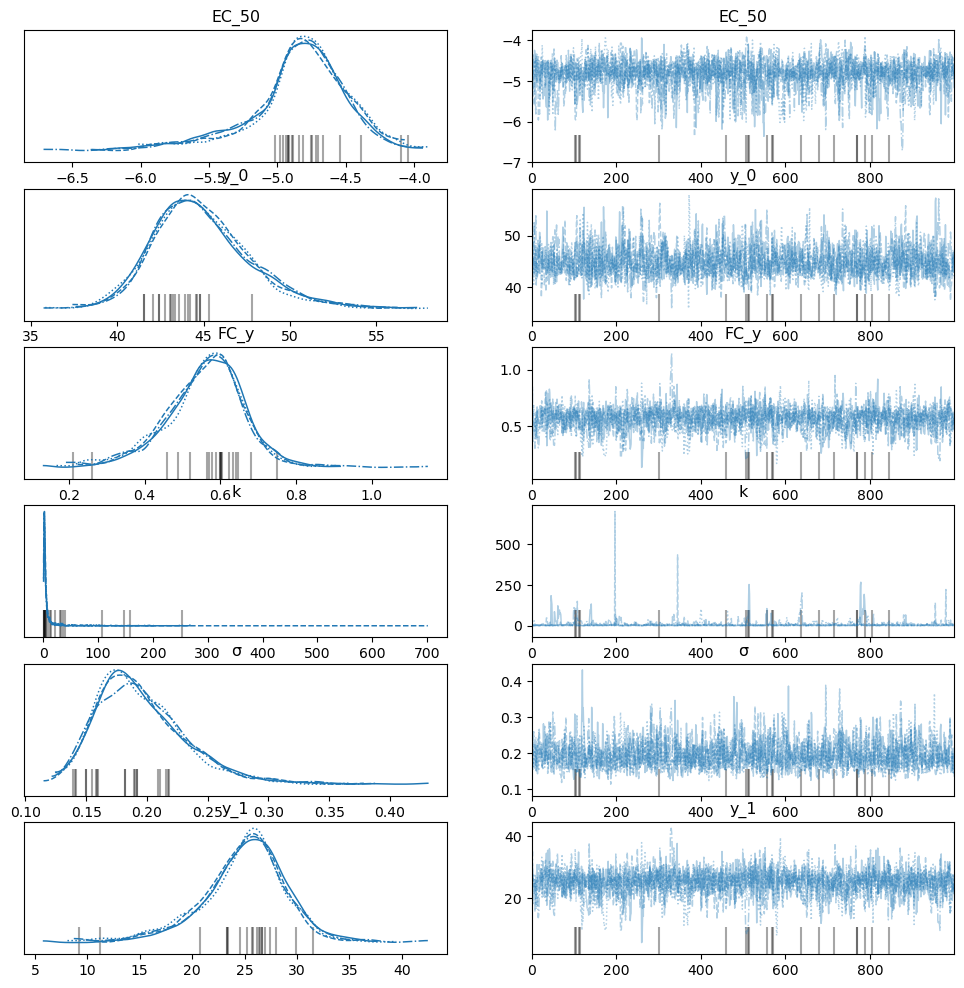

In [24]:
az.plot_trace(idata, var_names=var_names)

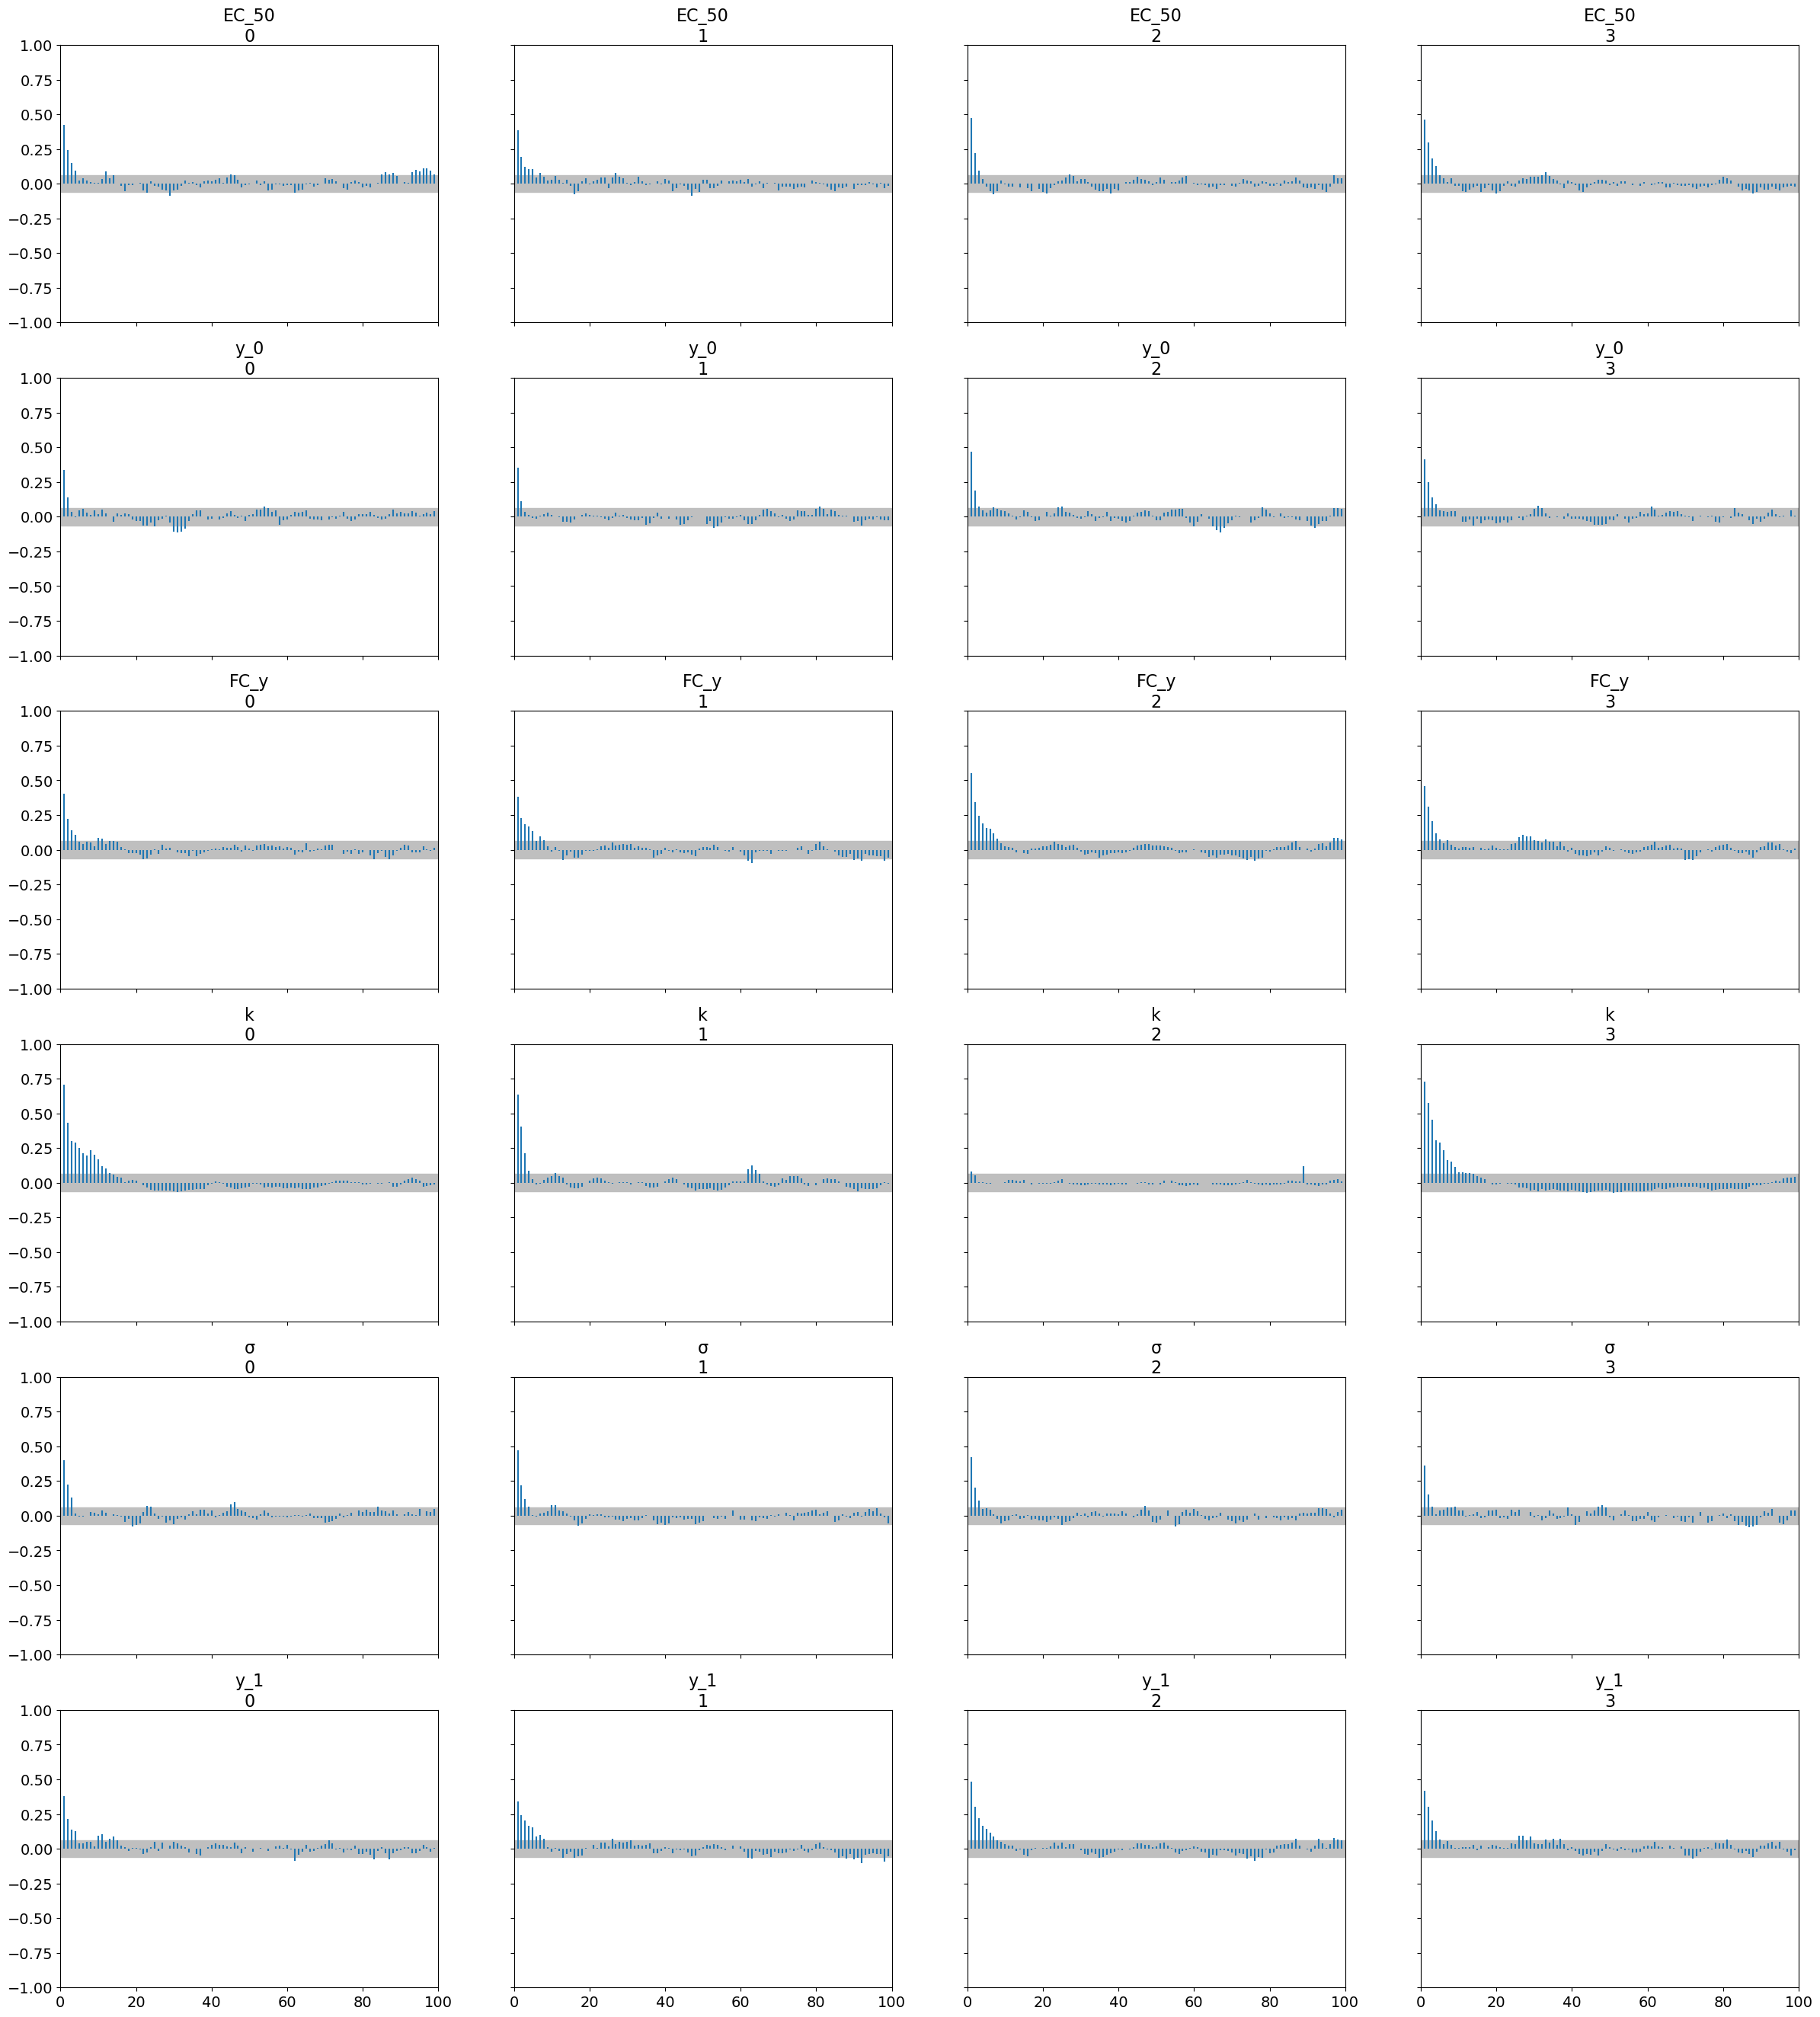

In [25]:
ax = az.plot_autocorr(idata, var_names=var_names)

array([[<AxesSubplot: title={'center': 'EC_50'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'y_0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'FC_y'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot: title={'center': 'k'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'σ'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot: title={'center': 'y_1'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

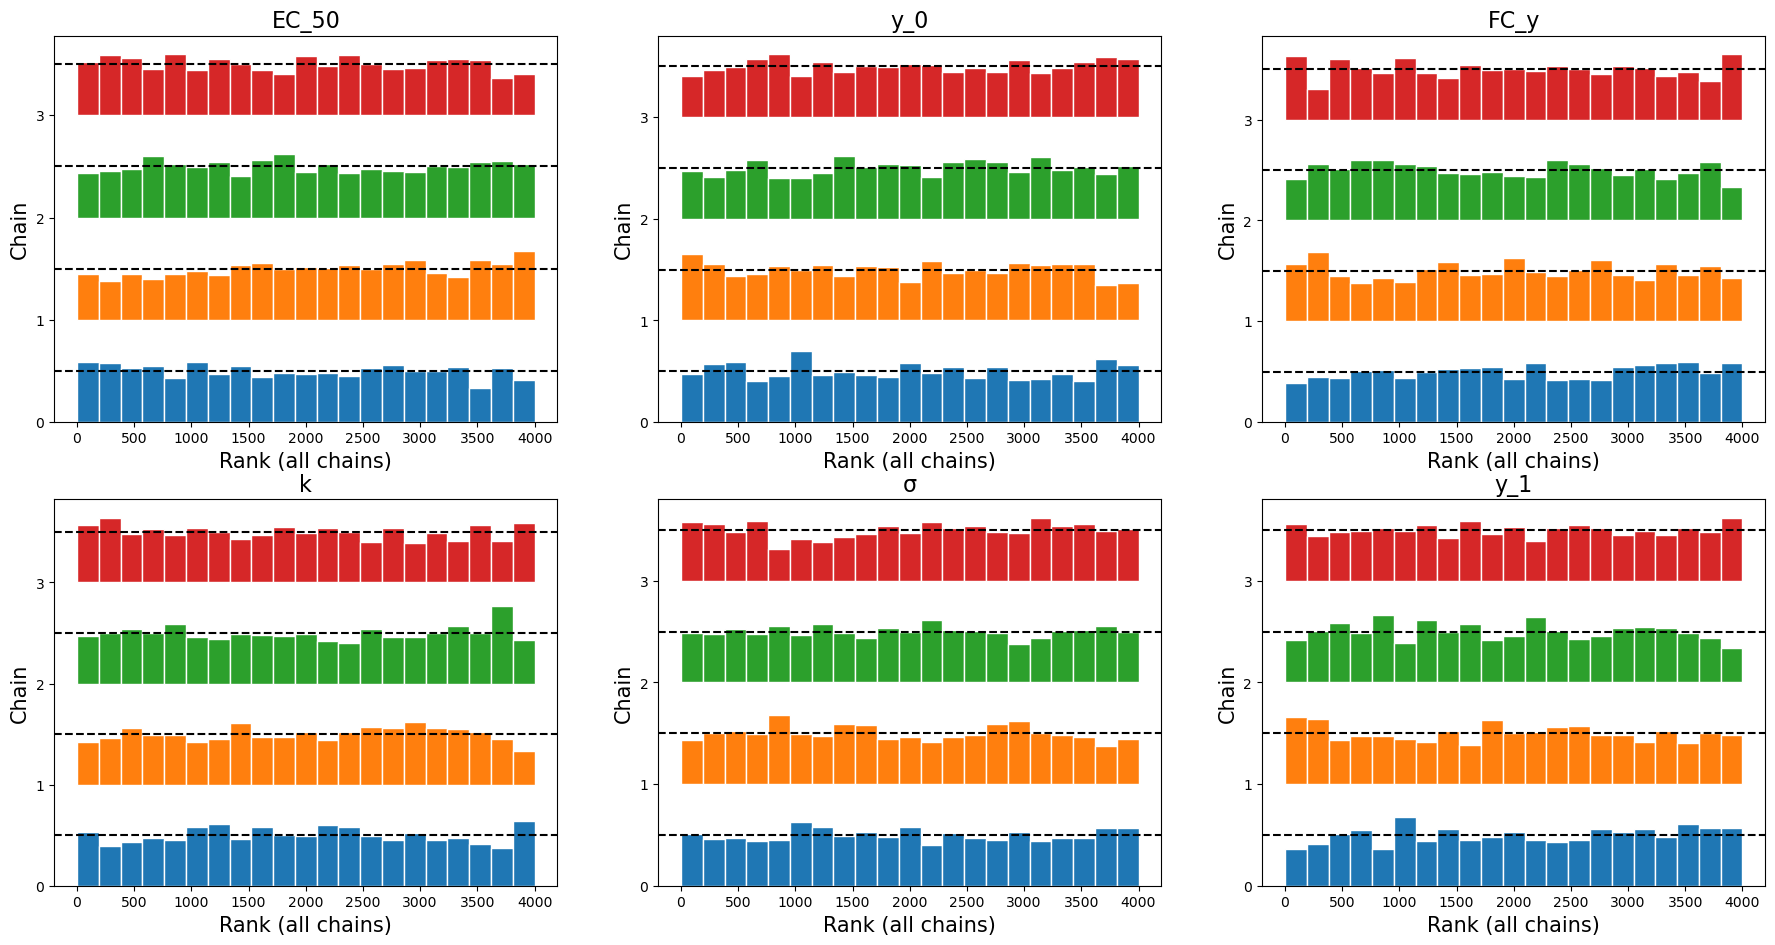

In [26]:
az.plot_rank(idata, var_names=var_names)

In [27]:
prior_samples = pm.sample_prior_predictive(1000, model)

Sampling: [EC_50, FC_y, k, y, y_0, σ]


Sampling: [EC_50, FC_y, k, y, y_0, σ]
/Users/jonesa7/CTNS/notebooks/src/cellbayesassay.py:244: RuntimeWarning: overflow encountered in exp
  yy = y_1 + (y_0 - y_1) / (1 + np.exp(k * (xx - EC_50)))


['named-figure/prior-posterior-curves.png',
 'named-figure/prior-posterior-curves.pdf']

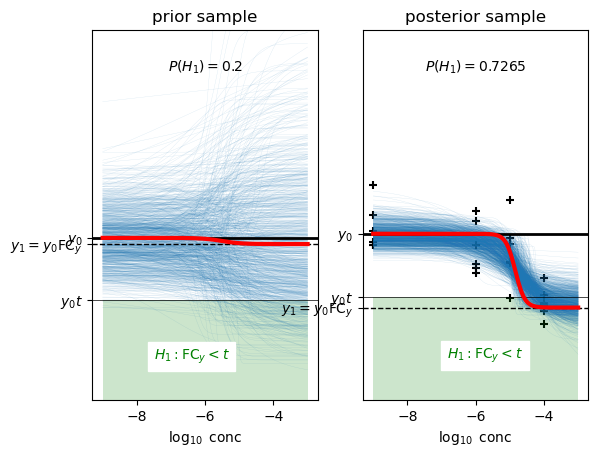

In [28]:
def prior_posterior_curves(model, idata, data_reshaped):
    H1_posterior_prob = cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=cba.default_H1_prior_prob)
    prior = pm.sample_prior_predictive(1000, model, random_seed=1986).prior
    fig, ax = plt.subplots(1, 2, sharey=False)
    for axi, data, title in zip(ax, [prior, idata.posterior], ['prior sample', 'posterior sample']):
        if title == 'posterior sample':
            axi = cba.plot_data(axi, data_reshaped)
            H1_prob = H1_posterior_prob
        else:
            H1_prob = cba.default_H1_prior_prob
        axi = cba.plot_sampled_curves_sigmoid(ax=axi, idata=data, data_reshaped=data_reshaped, alpha=0.2, draw_y0_y1=True)
        axi.axhline(0, color='k', linewidth=0.5)
        axi.set_title(title)
        axi.set_ylim(0, 100)
        axi.set_ylabel('')
        axi.text(0.5, 0.9, '$P(H_1) = {}$'.format(H1_prob), horizontalalignment='center', verticalalignment='center', transform=axi.transAxes)
    return((fig, ax))

fig, ax = prior_posterior_curves(model, idata, data_reshaped)
attila_utils.savefig(fig, 'prior-posterior-curves')

In [29]:
prior = 0.2
cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior)

0.7265

In [30]:
posterior_vs_prior = pd.concat([pd.DataFrame([prior, cba.get_H1_posterior_prob(idata.posterior['FC_y'], H1_increase=False, H1_prior_prob=prior)], columns=[prior], index=['prior', 'posterior']) for prior in np.arange(0.1, 0.6, 0.1)], axis=1).transpose()
posterior_vs_prior

,prior,posterior
0.1,0.1,0.21450
0.2,0.2,0.72650
0.3,0.3,0.96175
0.4,0.4,0.99450
0.5,0.5,0.99900


['named-figure/H1-prob-posterior-vs-prior.png',
 'named-figure/H1-prob-posterior-vs-prior.pdf']

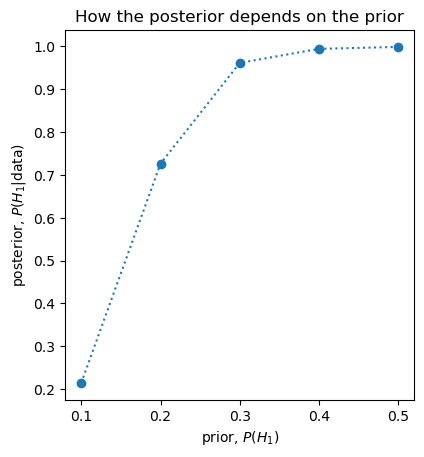

In [31]:
fig, ax = plt.subplots(figsize=(4.5, 4.8))
ax.plot('prior', 'posterior', data=posterior_vs_prior, marker='o', linestyle='dotted')
ax.set_xlabel('prior, $P(H_1)$')
ax.set_ylabel('posterior, $P(H_1 | \mathrm{data})$')
ax.set_title('How the posterior depends on the prior')
attila_utils.savefig(fig, 'H1-prob-posterior-vs-prior')

In [32]:
def fit_single(exper='Abeta release', assay='Aβ38', compound='TI21', datad=datad, controls=controls):
    data_reshaped = extract_regr_data(exper, assay, compound, datad=datad, controls=controls, return_data_reshaped=True)
    model, idata = [cba.sample_sigmoid_2(*extract_regr_data(exper, assay, compound), return_model=b) for b in [True, False]]
    index = pd.MultiIndex.from_product([[compound], ['model', 'idata']])
    df = pd.DataFrame([model, idata], index=index, columns=[assay]).transpose()
    return(df)


df = fit_single(exper='Abeta release', assay='Aβ38', compound='TI21')
df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.


TI21  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16a786610>   

                                                         
                                                  idata  
Aβ38  (posterior, log_likelihood, sample_stats, obse...

In [33]:
def fit_assay(exper='Abeta release', assay='Aβ38', datad=datad, controls=controls, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_single(exper=exper, assay=assay, compound=c, datad=datad, controls=controls) for c in compounds]
    df = pd.concat(l, axis=1)
    return(df)

ddf = fit_assay(exper='Abeta release', assay='Aβ38')
ddf

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


TI21  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16b823d50>   

                                                         \
                                                  idata   
Aβ38  (posterior, log_likelihood, sample_stats, obse...   

                                          TI22  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16be9a210>   

                                                         \
                                                  idata   
Aβ38  (posterior, log_likelihood, sample_stats, obse...   

                                          TI26  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16a786750>   

                                                         
                                                  idata  
Aβ38  (posterior, log_likelihood, sample_stats, obse...

In [34]:
def fit_exper(exper='Abeta release', datad=datad, controls=controls, assays=assays_Ab_release, compounds=['TI21', 'TI22', 'TI26']):
    l = [fit_assay(exper=exper, assay=a, datad=datad, controls=controls, compounds=compounds) for a in assays]
    df = pd.concat(l, axis=0)
    return(df)

dddf = fit_exper(exper='Abeta release')
dddf

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-A

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [EC_50, y_0, FC_y, k, σ]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


TI21  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16a8cba90>   
Aβ40  <pymc.model.Model object at 0x16362b1d0>   
Aβ42  <pymc.model.Model object at 0x16a632dd0>   

                                                         \
                                                  idata   
Aβ38  (posterior, log_likelihood, sample_stats, obse...   
Aβ40  (posterior, log_likelihood, sample_stats, obse...   
Aβ42  (posterior, log_likelihood, sample_stats, obse...   

                                          TI22  \
                                         model   
Aβ38  <pymc.model.Model object at 0x16b7764d0>   
Aβ40  <pymc.model.Model object at 0x16884d990>   
Aβ42  <pymc.model.Model object at 0x168d34ed0>   

                                                         \
                                                  idata   
Aβ38  (posterior, log_likelihood, sample_stats, obse...   
Aβ40  (posterior, log_likelihood, sample_stats, obse...   
Aβ42  (posterior, log_likelihood, sample_stats, obse...   

                                          TI26  \
                                         model   
Aβ38  <pymc.model.Model object at 0x168467f10>   
Aβ40  <pymc.model.Model object at 0x16363f650>   
Aβ42  <pymc.model.Model object at 0x16885d950>   

                                                         
                                                  idata  
Aβ38  (posterior, log_likelihood, sample_stats, obse...  
Aβ40  (posterior, log_likelihood, sample_stats, obse...  
Aβ42  (posterior, log_likelihood, sample_stats, obse...

In [35]:
%connect_info

{
  "shell_port": 54797,
  "iopub_port": 54798,
  "stdin_port": 54799,
  "control_port": 54801,
  "hb_port": 54800,
  "ip": "127.0.0.1",
  "key": "f440f37c-b81acd0e58fed9e1046c5f0d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-0ff66d66-1ea0-48fc-bbde-59ce6aeb8acc.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
